In [1]:
import warnings
from bs4 import BeautifulSoup
import pandas as pd
from pandas import DataFrame, read_csv
import scipy as sc
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn import metrics
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import PredictionError
from pandas.plotting import scatter_matrix



appleData=pd.read_csv(r'applestore.csv',header=0,index_col=0)
appleData.rename(columns={'track_name':'App','size_bytes':'sizeInMB','prime_genre':'Category',
                          'user_rating':'Rating','rating_count_tot':'RatingNum'},inplace=True)
appleData['sizeInMB'] = appleData['sizeInMB'].apply(lambda x: float(x/(1024*1024))) #from bytes to mb (x*10^-6)
appleData['sizeInMB'] = appleData['sizeInMB'].apply(lambda x: '{0:.3f}'.format(x))
appleData.drop(['currency', 'user_rating_ver','cont_rating','ipadSc_urls.num','vpp_lic','rating_count_ver'], axis=1,inplace=True)



c:\users\mor\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)



# Machine Learning Model to Predict Apps Rating In Apps Store
Our main question is **"Can i predict my application ratings?"**

Categorical Data Encoding:


We will convert categorical variables (text values) into numircal variables in order to make several ML algorithmes work properly.

In [2]:
le = preprocessing.LabelEncoder()
appleData['App'] = le.fit_transform(appleData['App'])

# This encoder converts the values into numeric value

# Encode Category features
category_list = appleData['Category'].unique().tolist() 
category_list = ['category_' + word for word in category_list]

appleData = pd.concat([appleData, pd.get_dummies(appleData['Category'], prefix='category')], axis=1)
#dummies columns for each category(1 yes,0 not in category)
appleData['Type'] = appleData['price'].apply(lambda x: 'Free' if x == 0 else 'Paid')

# Type encoding
appleData['Type'] = pd.get_dummies(appleData['Type']) 

#version into float:
regex = [r'[-+|/:/;(_)@]', r'\s+', r'[A-Za-z]+']
for j in regex:
    appleData['ver'] = appleData['ver'].astype(str).apply(lambda x : re.sub(j, '0', x))
    
    
appleData['ver'] = appleData['ver'].astype(str).apply(lambda x : x.replace('.', ',',1).replace('.', '').replace(',', '').replace(',', '.',1)).astype(float)
appleData['ver'] = appleData['ver'].fillna(appleData['ver'].median())
# appleData.to_csv(r'ApplestoreML.csv',index=False)


In [51]:
# Split data into training and testing sets
columns = [ 'price','RatingNum','sup_devices.num']
#app name is not relevant and also number of language supported.
columns.extend(category_list) #adds all the elements of an iterable to the end of the list.
X = appleData[columns]
y = appleData['Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
# splits the dataset into 75% train data and 25% test data.


- The k-nearest neighbors algorithm is based around the idea of predicting unknown values by matching them with the most similar known values.  To make a prediction for a new data point, the algorithm finds the closest data points in the training dataset — its "nearest neighbors". (As we learn in class)

Accuracy: 65.43%


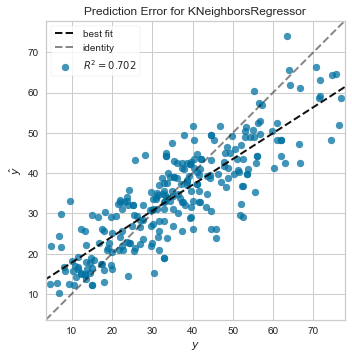

In [53]:
model = KNeighborsRegressor(n_neighbors=9)
# Find the mean accuracy of knn regression using X_test and y_test
model.fit(X_train, y_train)

                                              
# # calculates the mean accuracy of the KNN model
accuracy = model.score(X_test,y_test)
print('Accuracy: ' + str(np.round(accuracy*100, 2)) + '%')

# Load a regression dataset

X, y = load_concrete()

# Create the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Instantiate the linear model and visualizer
model = KNeighborsRegressor()
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()       



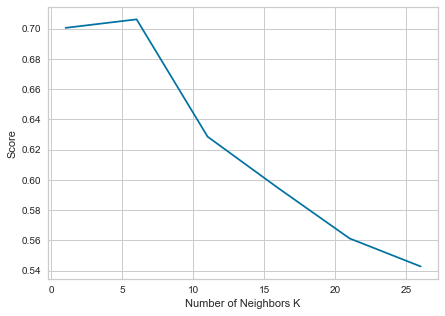

In [54]:
n_neighbors = np.arange(1, 30,5) #from 1 to 30 neighbors
scores = []
for n in n_neighbors:
    model.set_params(n_neighbors=n)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))
plt.figure(figsize=(7, 5))

plt.xlabel("Number of Neighbors K")
plt.ylabel("Score")
plt.plot(n_neighbors, scores)

So we got accuracy of 70% which is  good (but not good enough)
I'm going to try to improve the odds with several trees, Random forest algorithm.

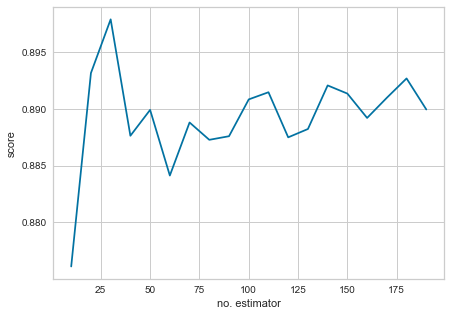

In [57]:
model = RandomForestRegressor(n_jobs=-1) #taking some time(not more than a minute)

estimators = np.arange(10, 200, 10)
scores = []
for n in estimators:
    model.set_params(n_estimators=n)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))
plt.figure(figsize=(7, 5))
plt.xlabel("no. estimator")
plt.ylabel("score")
plt.plot(estimators, scores)

We can see there is improvment (89% +).


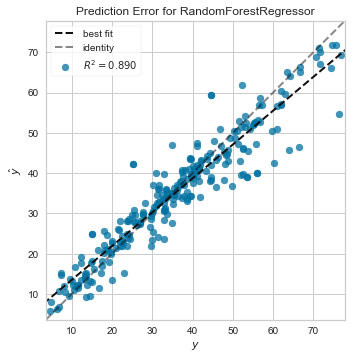

In [58]:
# Load a regression dataset
X, y = load_concrete()

# Create the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Instantiate the linear model and visualizer
model = RandomForestRegressor()
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

- The R^2 score that specifies the goodness of fit of the underlying regression model to the test data.

- We can see that the score is high, that mean this model can predict rating(y) in a very good way.


now on this Machine learning chapter, we can try and guess the Rating of the application before it even will be published, by setting values before (like price ,category, number of supported device) **that's amazing**.

It gives the application developer a way to follow (if they wan't good Rating - who dosen't?).

# Another methods in Machine learning

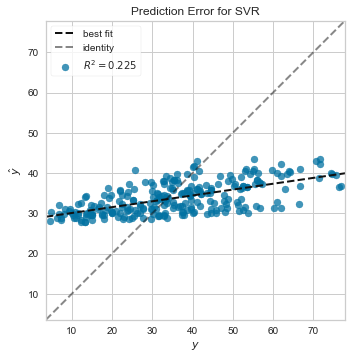

In [72]:
from sklearn.svm import SVR
from sklearn import svm

# Load a regression dataset

X, y = load_concrete()


# # Instantiate the linear model and visualizer
model = svm.SVR()
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()       

In [75]:
#necessary import
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
# Split data into training and testing sets
columns = [ 'price','RatingNum','sup_devices.num']
#app name is not relevant and also number of language supported.
columns.extend(category_list) #adds all the elements of an iterable to the end of the list.
X = appleData[columns]
y = appleData['Rating'].astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
# splits the dataset into 75% train data and 25% test data.

gnb = GaussianNB()
# Train classifier
gnb.fit(X_train,y_train)
y_pred = gnb.predict(X_test)
y_pred_train = gnb.predict(X_train)
# Print results
print('Accuracy on Train data= ', metrics.accuracy_score(y_true= y_train, y_pred = y_pred_train))
print('Accuracy on test data= ', metrics.accuracy_score(y_true= y_test, y_pred = y_pred))



Accuracy on Train data=  0.4272384355767322
Accuracy on test data=  0.45416666666666666


- As we can see KNN algorithm fits the most to this dataset, and can predicts almost two time more than the other algorithms i checkd.